In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools

from utilities import *
from analysis import *

In [2]:
sns.set_palette("tab10")
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
loaded = False

# Load BioBank Components

In [4]:
DEV_MODE = False
SIGNIFIER = ""

if not loaded:
    (biobank_data_no_HLA_alleles, biobank_index,
     med_code_mapping) = data_tools.load_all_biobank_components(DEV_MODE, signifier=SIGNIFIER)
    loaded = True
    HLA_alleles = data_tools.load_HLA_data()
    biobank_data = biobank_data_no_HLA_alleles.merge(HLA_alleles, how="left", on="eid")

Importing BioBank Index and Data:
Missing 0 biobank index names
Reduced feature set has 376 features.
UK BioBank Data Loaded.
Size: 502536 rows x 376 columns
Elapsed time: 62.2902 seconds


Mapping Medical Codes:   0%|          | 0/361 [00:00<?, ? feature/s]

In [5]:
biobank_data

,eid,sex,birth_year,birth_month,assessment_date,n_cancers,n_cancers_1.0,n_cancers_2.0,n_non_cancer_illnesses,n_non_cancer_illnesses_1.0,...,operative_procedures_OPCS4_secondary,A1,A2,B1,B2,C1,C2,zygosity,effective_zygosity,grantham_divergence
0,1000013,Male,1962.0,April,2008-02-19,0.0,NaN,NaN,2.0,NaN,...,NaN,A*02:01,A*02:01,B*44:02,B*57:01,C*05:01,C*06:02,1.0,1.0,31.481250
1,1000024,Female,1941.0,January,2010-06-04,1.0,NaN,NaN,0.0,NaN,...,Z50.4 Skin of leg NEC,A*01:01,A*01:01,B*07:02,B*08:01,C*07:01,C*07:02,1.0,1.0,32.060417
2,1000036,Female,1955.0,August,2009-02-11,1.0,NaN,NaN,0.0,NaN,...,T87.3 Excision or biopsy of axillary lymph node,A*02:01,A*34:02,B*14:01,B*44:02,C*05:01,C*08:02,0.0,0.0,30.402083
3,1000048,Male,1941.0,April,2009-10-26,0.0,NaN,NaN,2.0,NaN,...,NaN,A*02:01,A*68:01,B*07:02,B*51:01,C*01:02,C*07:02,0.0,0.0,34.847917
4,1000055,Female,1947.0,October,2008-03-06,0.0,NaN,NaN,4.0,NaN,...,K40.1 Saphenous vein graft replacement of one ...,A*01:01,A*03:01,B*13:02,B*57:01,C*06:02,C*06:02,1.0,1.0,33.218750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502531,6025324,Female,1967.0,April,2009-07-04,0.0,NaN,0.0,1.0,NaN,...,H22.9 Unspecified diagnostic endoscopic examin...,A*01:01,A*01:01,B*08:01,B*57:01,C*06:02,C*07:01,1.0,1.0,34.416667
502532,6025336,Female,1964.0,August,2008-05-16,1.0,NaN,NaN,5.0,NaN,...,Q22.1 Bilateral salpingoophorectomy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502533,6025348,Male,1945.0,October,2010-02-18,0.0,NaN,NaN,0.0,NaN,...,Y75.2 Laparoscopic approach to abdominal cavit...,A*24:02,A*24:02,B*15:01,B*51:01,C*02:02,C*03:03,1.0,1.0,33.577083
502534,6025355,Female,1947.0,November,2008-06-28,0.0,NaN,NaN,4.0,NaN,...,Y84.8 Other specified other anaesthetic,A*02:01,A*03:01,B*15:01,B*44:02,C*03:04,C*05:01,0.0,0.0,28.656250


# Constants

In [6]:
female_specific_cancers = ["breast cancer", "female genital tract cancer", "cervical cancer",
                           "cin/pre-cancer cells cervix", "fallopian tube cancer", "ovarian cancer",
                           "uterine/endometrial cancer", "vaginal cancer", "vulval cancer" ]

male_specific_cancers = ["male genital tract cancer", "penis cancer", "prostate cancer", "testicular cancer"]
sex_specific_cancers = female_specific_cancers + male_specific_cancers

# Viral Codes

In [7]:
mononucleosis_code = 'infectious mononucleosis / glandular fever / epstein barr virus (ebv)'
hiv_code = 'hiv/aids'
herpes_simplex_code = "herpes simplex"
hepatitis_code = "infective/viral hepatitis"

data_tools.biobank_search(med_code_mapping, biobank_data, ('alz'))

,coding,meaning,code_format,name,count
136,1263,dementia/alzheimers/cognitive impairment,6,illness_code,39
2619,3310,3310 Alzheimer's disease,87,cancer_type_ICD9,0
456,1140856246,salzone 120mg/5ml syrup,4,treatment_code,0
2709,F00,F00 Dementia in Alzheimer's disease,19,cancer_type_ICD10,0
2710,F000,F00.0 Dementia in Alzheimer's disease with ear...,19,cancer_type_ICD10,0
2711,F001,F00.1 Dementia in Alzheimer's disease with lat...,19,cancer_type_ICD10,0
2712,F002,F00.2 Dementia in Alzheimer's disease; atypica...,19,cancer_type_ICD10,0
2713,F009,F00.9 Dementia in Alzheimer's disease; unspeci...,19,cancer_type_ICD10,0
3270,G30,G30 Alzheimer's disease,19,cancer_type_ICD10,0
3271,G300,G30.0 Alzheimer's disease with early onset,19,cancer_type_ICD10,0


 # Exploring ICD 10 Cancer Types

In [8]:
ICD10_data = biobank_data.loc[~biobank_data["cancer_type_ICD10"].isna()].copy(deep=True)

In [9]:
display(data_tools.biobank_search(med_code_mapping, biobank_data, ("C82")).query("name == 'cancer_type_ICD10'"))
display(data_tools.biobank_search(med_code_mapping, biobank_data,
                                  ("non-hodg")).query("name == 'cancer_type_ICD10' and count != 0"))

,coding,meaning,code_format,name,count
1638,C829,C82.9 Follicular non-Hodgkin's lymphoma; unspe...,19,cancer_type_ICD10,301
1631,C821,C82.1 Mixed small cleaved and large cell; foll...,19,cancer_type_ICD10,77
1630,C820,C82.0 Small cleaved cell; follicular,19,cancer_type_ICD10,41
1632,C822,C82.2 Large cell; follicular,19,cancer_type_ICD10,40
1637,C827,C82.7 Other types of follicular non-Hodgkin's ...,19,cancer_type_ICD10,23
1629,C82,C82 Follicular [nodular] non-Hodgkin's lymphoma,19,cancer_type_ICD10,0
1633,C823,C82.3 Follicular lymphoma grade IIIa,19,cancer_type_ICD10,0
1634,C824,C82.4 Follicular lymphoma grade IIIb,19,cancer_type_ICD10,0
1635,C825,C82.5 Diffuse follicle centre lymphoma,19,cancer_type_ICD10,0
1636,C826,C82.6 Cutaneous follicle centre lymphoma,19,cancer_type_ICD10,0


,coding,meaning,code_format,name,count
1638,C829,C82.9 Follicular non-Hodgkin's lymphoma; unspe...,19,cancer_type_ICD10,301
1666,C859,C85.9 Non-Hodgkin's lymphoma; unspecified type,19,cancer_type_ICD10,237
1648,C838,C83.8 Other types of diffuse non-Hodgkin's lym...,19,cancer_type_ICD10,117
1665,C857,C85.7 Other specified types of non-Hodgkin's l...,19,cancer_type_ICD10,115
1637,C827,C82.7 Other types of follicular non-Hodgkin's ...,19,cancer_type_ICD10,23
1649,C839,C83.9 Diffuse non-Hodgkin's lymphoma; unspecified,19,cancer_type_ICD10,14


In [10]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7125417/
viral_associated_cancers = ["hodgkin's lymphoma", "gastric carcinoma", "burkitt's lymphoma", "nasopharyngeal carcinoma"]
ICD10_viral_associated_cancer_labels = {
    "burkitt's lymphoma": ["C83.7"],
    "nasopharyngeal carcinoma": ["C11"],
    "gastric carcinoma": ["C16", "D37.1"],
    "hodgkin's disease": ["C81.9", "C81.7"],
    "kaposi's sarcoma": ["C46"],
    "liver cancer": ["C22"],
#     "anal cancer": ["C21"],
#     "non-hodgkin's lymphoma": ["C82.9", "C82.7", "C83.8", "C85.7", "C83.9"]
}

viral_labels = {
    "mononucleosis_code": 'infectious mononucleosis / glandular fever / epstein barr virus (ebv)',
    "hiv_code": 'hiv/aids',
    "herpes_simplex_code": "herpes simplex",
    "hepatitis_code": "infective/viral hepatitis"
}

antiviral_labels = {"acyclovir": "clovir"}

ICD10_viral_associated_cancer_labels

{"burkitt's lymphoma": ['C83.7'],
 'nasopharyngeal carcinoma': ['C11'],
 'gastric carcinoma': ['C16', 'D37.1'],
 "hodgkin's disease": ['C81.9', 'C81.7'],
 "kaposi's sarcoma": ['C46'],
 'liver cancer': ['C22']}

In [11]:
def apply_grouping(variable_tag: str, grouping: dict, default: str = None) -> str:
    """"""
    if isinstance(variable_tag, float):
        return default
    
    for label, tag_set in grouping.items():
        if isinstance(tag_set, str):
            if tag_set in variable_tag:
                return label
            continue

        for tag in tag_set:
            if tag in variable_tag:
                return label

    return default

def apply_tuple_grouping(variable_tag: str, grouping: tuple, default: str = None) -> str:
    """"""
    if isinstance(variable_tag, float):
        return default
    
    for label, tag_set in grouping:
        if isinstance(tag_set, str):
            if tag_set in variable_tag:
                return label
            continue

        for tag in tag_set:
            if tag in variable_tag:
                return label

    return default

# def multicolumn_apply_grouping() 

In [12]:
base_feature = "illness_code"
params = dict(grouping=[(True, "infective/viral hepatitis"), (True, "hepatitis a")], default=False)

features = [feature for feature in ICD10_data.columns if feature.startswith(base_feature + "_0")]
aggregated_feature_values = ICD10_data[features[0]].apply(apply_tuple_grouping, **params)

for feature in features[1:]:
    found_values = ICD10_data[feature].apply(apply_tuple_grouping, **params)
    aggregated_feature_values = aggregated_feature_values | found_values
    
ICD10_data["infective/viral hepatitis"] = aggregated_feature_values * 1

In [13]:
ICD10_data["viral_infection"] = ICD10_data["illness_code"].apply(apply_grouping, grouping=viral_labels,
                                                                 default="no viral illness")
ICD10_data["given_antiviral"] = ICD10_data["treatment_code"].apply(apply_grouping, grouping=antiviral_labels,
                                                                 default="no antiviral")

In [14]:
ICD10_data["virus_associated_cancer"] = ICD10_data["cancer_type_ICD10"].apply(apply_grouping, 
                                                                              grouping=ICD10_viral_associated_cancer_labels,
                                                                              default="non-virus associated")

biobank_data["virus_associated_cancer"] = biobank_data["cancer_type_ICD10"].apply(apply_grouping, 
                                                                              grouping=ICD10_viral_associated_cancer_labels,
                                                                              default="non-virus associated")

In [15]:
biobank_data["virus_associated_cancer"].loc[biobank_data["cancer_type_ICD10"].isna()] = "no cancer"

<ipython-input-15-9a5cdfa039cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biobank_data["virus_associated_cancer"].loc[biobank_data["cancer_type_ICD10"].isna()] = "no cancer"


# Viral Associated Summary Statistics

In [16]:
variables_of_interest = ["sex"]
grouping = ["virus_associated_cancer"]
extra = ["zygosity"]

grouping_df = biobank_data[grouping + variables_of_interest + extra].copy(deep=True)
grouping_df["total"] = grouping_df[variables_of_interest[0]] != "nothing"

for variable in variables_of_interest:
    for variable_option in sorted(grouping_df[variable].unique()):
        grouping_df[variable_option.lower().replace(" ", "_")] = grouping_df[variable] == variable_option

grouping_df = grouping_df.groupby(grouping).sum().reset_index()

# for variable in exclude(grouping_df.columns, grouping + ["total"]):
#     grouping_df[variable + "_fraction"] = grouping_df[variable] / grouping_df["total"]

grouping_df = grouping_df.sort_values("total", ascending=False)
grouping_df["zygosity"] /= grouping_df["total"]
grouping_df = grouping_df.rename({"zygosity": "mean_hla_homozygosity"}, axis=1)
display(grouping_df)

,virus_associated_cancer,mean_hla_homozygosity,total,female,male
6,no cancer,0.314676,419053,227161,191892
7,non-virus associated,0.324993,82488,45897,36591
1,gastric carcinoma,0.316929,508,166,342
4,liver cancer,0.292308,325,118,207
2,hodgkin's disease,0.400000,90,42,48
5,nasopharyngeal carcinoma,0.187500,32,14,18
0,burkitt's lymphoma,0.400000,25,4,21
3,kaposi's sarcoma,0.066667,15,0,15


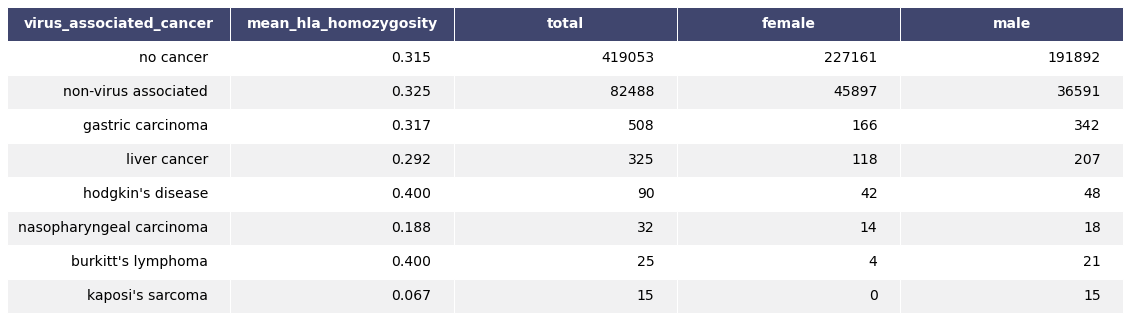

In [17]:
data = grouping_df.copy(deep=True)
data["mean_hla_homozygosity"] = data["mean_hla_homozygosity"].apply(lambda s: f"{s:.3f}")
fig, ax = render_mpl_table(data, header_columns=0, col_width=4.0)
fig.savefig("cancer_ICD10_plots/viral_associated_cancer_summary_table.png")
grouping_df = grouping_df.loc[~ grouping_df["virus_associated_cancer"].isin(["no cancer", "non-virus associated"])]

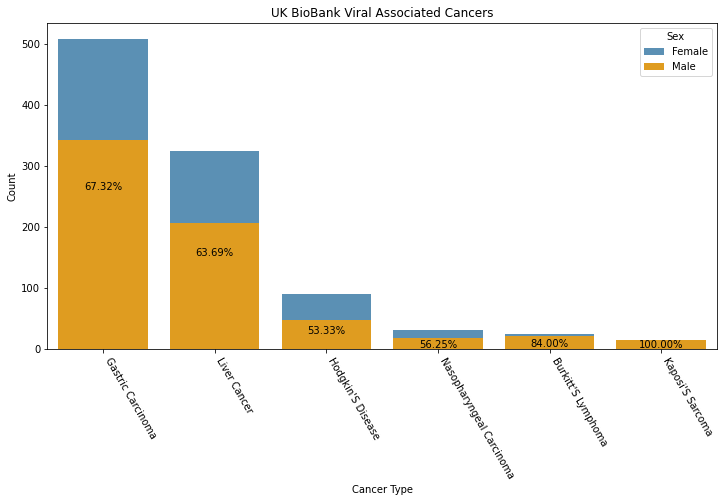

In [18]:
data = grouping_df
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=data, x="virus_associated_cancer", y="total", color="C0", alpha=.8, label="Female")
sns.barplot(data=data, x="virus_associated_cancer", y="male", color="orange", alpha=1, label="Male")

i = 0
for y_i, frac_male in zip(data["male"], data["male"] / data["total"]):
    ax.text(i, max(y_i * .8, 15), f"{frac_male * 100:.02f}%", ha="center", va="top")
    i += 1

add_plt_labels(ax=ax, x="Cancer Type", y="Count")
ax.legend(title="Sex")
ax.set_title("UK BioBank Viral Associated Cancers")
ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");
fig.savefig("cancer_ICD10_plots/viral_associated_cancer_summary.png")

# Viral Associated Age of Diagnosis Plots 

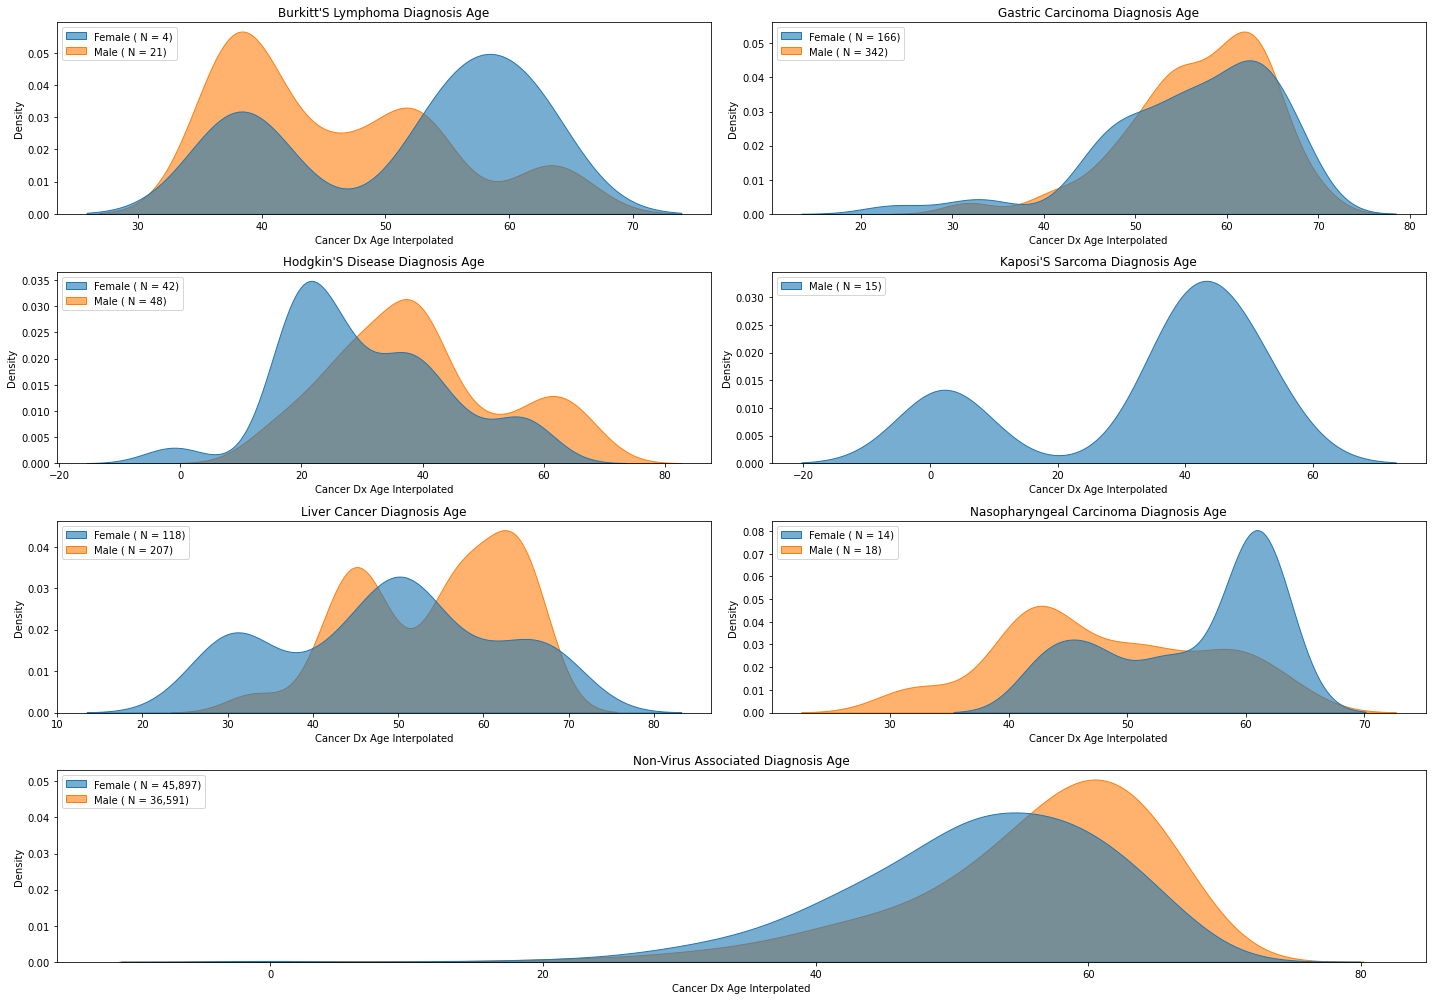

In [19]:
grouping = ICD10_data.groupby(["virus_associated_cancer"])
grouping = {label: subset for label, subset in grouping}

x, y, hue = "cancer_dx_age_interpolated", "density", "sex"

fig, axes = create_subplot(len(grouping), width=20, height_per=3)
for (cancer_type, subset), ax in zip(ICD10_data.groupby(["virus_associated_cancer"]), axes):
    sns_wrapper(sns.kdeplot, data=subset, x=x, hue=hue, ax=ax, bw_method=.35, common_norm=False, shade=True)
#     sns.histplot(data=subset, x=x, hue=hue, ax=ax, multiple="dodge", alpha=.3)
    add_plt_labels(ax, x=x, y=y)
    ax.set_title(f"{cancer_type.title()} Diagnosis Age")
    ax.legend(loc="upper left")

fig.tight_layout()
fig.savefig("cancer_ICD10_plots/viral_associated_cancer_age_dx.png")

<AxesSubplot:xlabel='virus_associated_cancer', ylabel='cancer_dx_age_interpolated'>

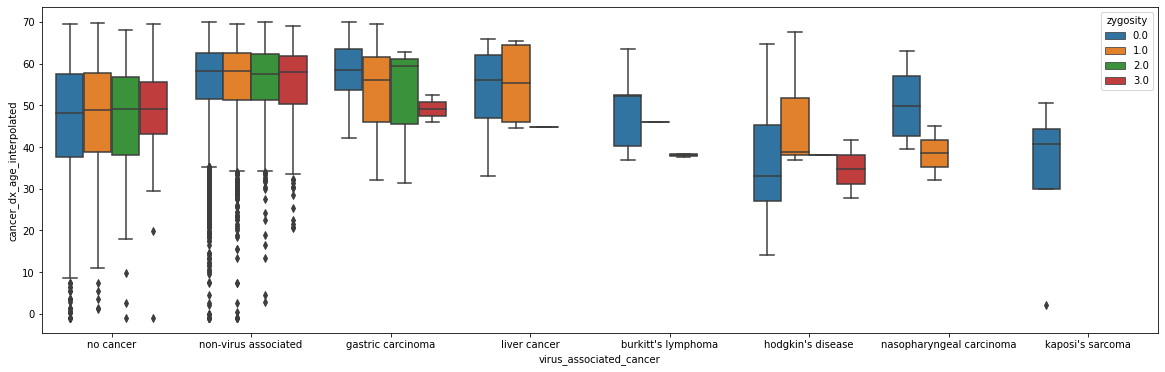

In [20]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.boxplot(data=biobank_data.query("sex == 'Male'"), x="virus_associated_cancer", hue="zygosity", y=x, ax=ax)
# add_plt_labels(ax, x="Number of Homozygous HLA Alleles", y=x)

<ipython-input-21-9cd323754397>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");


(-0.2, 8.4)

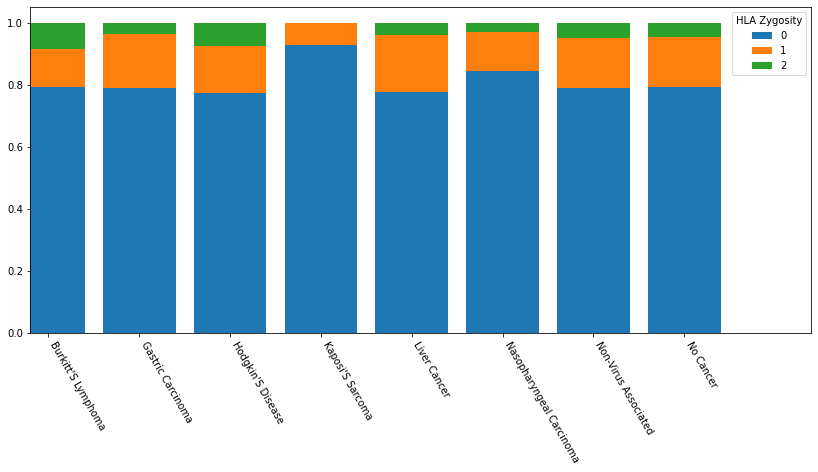

In [21]:
cancer_types = sorted(biobank_data["virus_associated_cancer"].unique())
cancer_types = [c for c in cancer_types if c != "no cancer"] + ["no cancer"]

values = []
for zygosity in range(3):
    data = biobank_data.query(f"zygosity == {zygosity}")
    values.append([(data["virus_associated_cancer"] == cancer_type).sum() for cancer_type in cancer_types])
values = np.cumsum(values, axis=0)
counts = values[-1]
values = values / counts

fig, ax = plt.subplots(figsize=(14, 6))
for i, value_set in zip(range(3), values):
    ax.bar(cancer_types, value_set, label=i, zorder=- i)

ax.legend(title="HLA Zygosity")
plt.draw()
ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");
ax.set_xlim(-.2, len(counts) + .4)

/Users/cole/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/cole/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


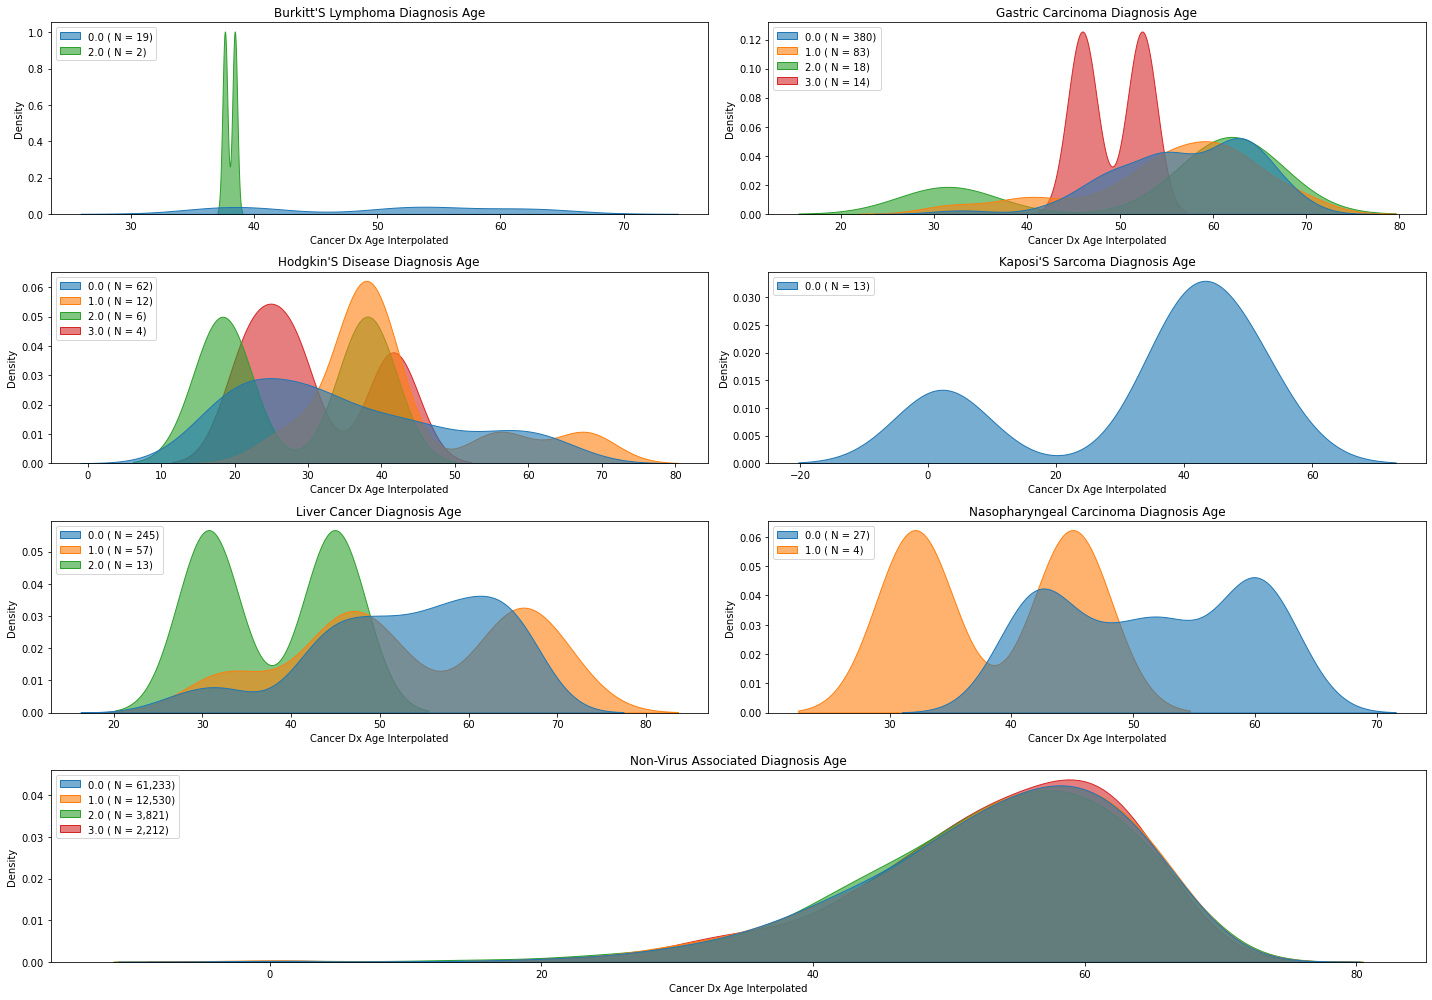

In [22]:
grouping = ICD10_data.query("sex == 'Male'").groupby(["virus_associated_cancer"])
grouping = {label: subset for label, subset in grouping}

x, y, hue = "cancer_dx_age_interpolated", "density", "zygosity"

fig, axes = create_subplot(len(grouping), width=20, height_per=3)
for (cancer_type, subset), ax in zip(ICD10_data.groupby(["virus_associated_cancer"]), axes):
    sns_wrapper(sns.kdeplot, data=subset, x=x, hue=hue, ax=ax, bw_method=.35, common_norm=False, shade=True)
#     sns.histplot(data=subset, x=x, hue=hue, ax=ax, multiple="dodge", alpha=.3)
    add_plt_labels(ax, x=x, y=y)
    ax.set_title(f"{str(cancer_type).title()} Diagnosis Age")
    ax.legend(loc="upper left")

fig.tight_layout()
fig.savefig("cancer_ICD10_plots/viral_associated_cancer_age_dx.png")

# Full ICD10 Analysis

In [23]:
from analysis import *

In [43]:
all_cancer_type_ICD10 = biobank_data[get_multiple_features_from_base_feature(biobank_data,
                                                                             "cancer_type_ICD10")].values.ravel()
all_cancers, counts = np.unique(all_cancer_type_ICD10[~pd.isnull(all_cancer_type_ICD10)], return_counts=True)
# all_cancers, counts = all_cancers[counts > 10], counts[counts > 10]

for cancer, count in zip(all_cancers, counts):
    print(count, "|", cancer)

13 | C00.0 External upper lip
17 | C00.1 External lower lip
4 | C00.2 External lip; unspecified
1 | C00.3 Upper lip; inner aspect
2 | C00.4 Lower lip; inner aspect
1 | C00.5 Lip; unspecified; inner aspect
1 | C00.6 Commissure of lip
10 | C00.9 Lip; unspecified
150 | C01 Malignant neoplasm of base of tongue
5 | C02.0 Dorsal surface of tongue
85 | C02.1 Border of tongue
21 | C02.2 Ventral surface of tongue
2 | C02.3 Anterior two-thirds of tongue; part unspecified
16 | C02.4 Lingual tonsil
2 | C02.8 Overlapping lesion of tongue
109 | C02.9 Tongue; unspecified
10 | C03.0 Upper gum
36 | C03.1 Lower gum
11 | C03.9 Gum; unspecified
15 | C04.0 Anterior floor of mouth
7 | C04.1 Lateral floor of mouth
1 | C04.8 Overlapping lesion of floor of mouth
42 | C04.9 Floor of mouth; unspecified
18 | C05.0 Hard palate
34 | C05.1 Soft palate
3 | C05.2 Uvula
2 | C05.8 Overlapping lesion of palate
10 | C05.9 Palate; unspecified
38 | C06.0 Cheek mucosa
3 | C06.1 Vestibule of mouth
21 | C06.2 Retromolar area
4

In [24]:
get_illness_value(biobank_data, ["C43"], "cancer_type_ICD10").sum()

3693

['cancer_type_ICD10',
 'cancer_type_ICD10_1.0',
 'cancer_type_ICD10_2.0',
 'cancer_type_ICD10_3.0',
 'cancer_type_ICD10_4.0',
 'cancer_type_ICD10_5.0',
 'cancer_type_ICD10_6.0',
 'cancer_type_ICD10_7.0']